In [2]:
import numpy as np
import matplotlib.pyplot as plt
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
import compute_S_rate
import auxiliary_functions
import seaborn
import math

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [3]:
time = [i for i in np.linspace(1,20,200)]
N = 50

### First Approximation of the S curve

In [4]:
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N-1))
F = lambda t: np.log(N) * (1 - np.exp(-t))
K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))
#C = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))

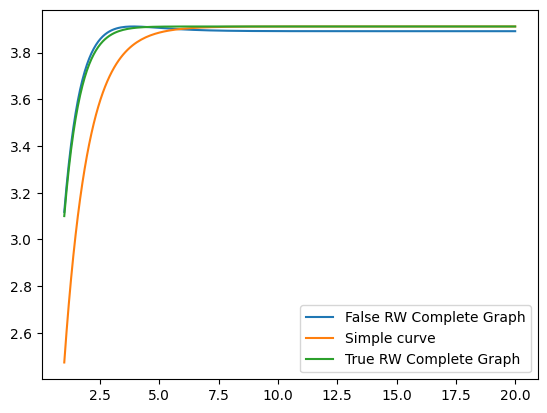

In [5]:
plt.plot(time, [H(t) for t in time], label='False RW Complete Graph')
plt.plot(time, [F(t) for t in time], label='Simple curve')
plt.plot(time, [K(t,N) for t in time], label='True RW Complete Graph')
plt.legend()

## RW-complete Graph

In [6]:
complete_graph_adj = np.ones((N,N)) - np.diag(np.ones(N),0)

complete_graph_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(complete_graph_adj))
complete_graph_rw.compute_laplacian_matrices(random_walk = True)

complete_graph_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
complete_graph_rw.compute_transition_matrices(lamda=1)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [7]:
H_complete_rw = compute_S_rate.compute_conditional_entropy(net=complete_graph_rw, list_T=complete_graph_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(0, len(time)-1)))

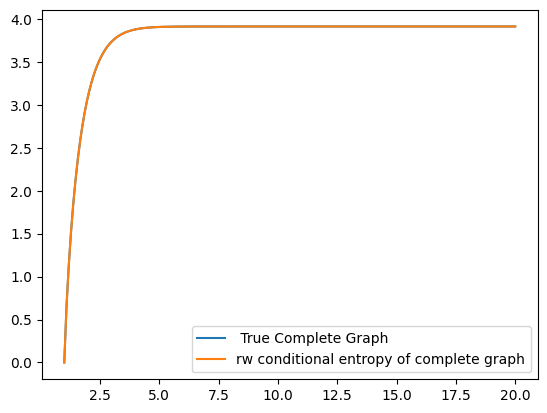

In [8]:
t0 = time[0]
plt.plot(time, [0] + [K(t-t0, N) for t in time[1:]], label=' True Complete Graph')
plt.plot(time, H_complete_rw[list(H_complete_rw.keys())[0]], label='rw conditional entropy of complete graph')
plt.legend()

In [9]:
# Just to show that the entropy production rate is equal to 0 in static networks.


# list_T = complete_graph_rw.T[1]
# list_L = [complete_graph_rw.laplacians] * len(list_T)
# S_complete_rw = compute_S_rate.compute_entropy_rate(net=complete_graph_rw, list_T=list_T, lamda=1, force_csr=True, time_domain= list(range(len(list_T))))

# plt.plot(time, S_complete_rw[list(S_complete_rw.keys())[0]], label='rw entropy production rate of complete graph')
# plt.legend()

## Heat-Complete Graph

In [10]:
complete_graph_heat = StaticTempNetwork(times = time, adjacency = csr_matrix(complete_graph_adj))
complete_graph_heat.compute_laplacian_matrices(random_walk = False)

complete_graph_heat.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
complete_graph_heat.compute_transition_matrices(lamda=1)

In [11]:
S_complete_heat = compute_S_rate.compute_conditional_entropy(net=complete_graph_heat, list_T=complete_graph_heat.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(0, len(time)-2)))

## RW-ER-Graph

In [12]:
import networkx as nx

In [13]:
p= 5/N
c= 5
er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(N, p))

In [14]:
er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
er_rw.compute_laplacian_matrices(random_walk = True)

er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
er_rw.compute_transition_matrices(lamda=1)


er_heat = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
er_heat.compute_laplacian_matrices(random_walk = False)

er_heat.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
er_heat.compute_transition_matrices(lamda=1)

In [15]:
H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(0, len(time)-2)))
H_er_heat = compute_S_rate.compute_conditional_entropy(net=er_heat, list_T=er_heat.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(0, len(time)-2)))

In [16]:
print(H_er_rw[list(H_er_rw.keys())[0]][-1])
print(H_er_heat[list(H_er_heat.keys())[0]][-1])
print(np.log(N))

3.8028164476289077
3.9120230054197322
3.912023005428146


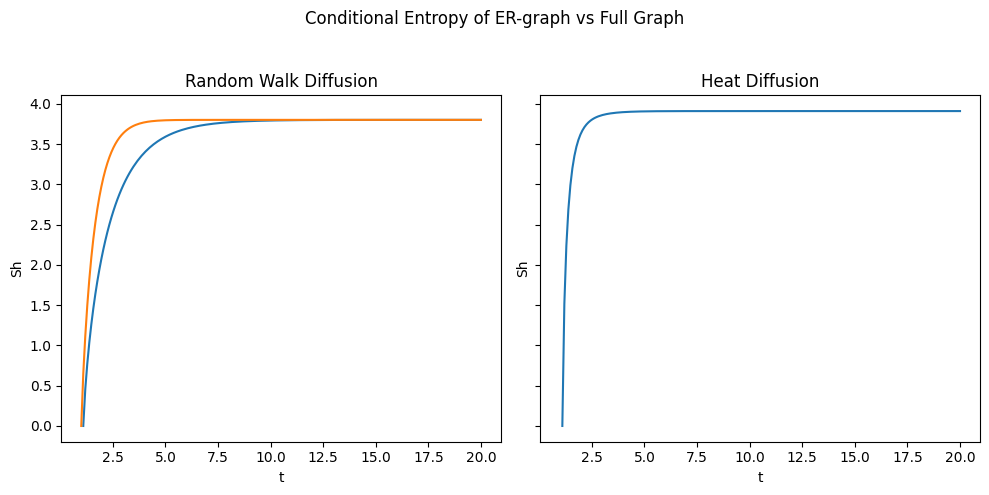

In [17]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))

####### RW Plot


axs[0].set_xlabel('t')
axs[0].set_ylabel('Sh')
axs[0].tick_params(axis='y')


axs[0].plot(time[1:], H_er_rw[list(H_er_rw.keys())[0]], label='rw conditional entropy of ER-graph')
asymptot = np.exp(H_er_rw[list(H_er_rw.keys())[0]][-1])
axs[0].plot(time, [0] + [K(t-t0, asymptot) for t in time[1:]], label='Reference full graph')


# Heat Plot

axs[1].set_xlabel('t')
axs[1].set_ylabel('Sh')
axs[1].tick_params(axis='y')


axs[1].plot(time[1:], H_er_heat[list(H_er_heat.keys())[0]], label='heat conditional entropy of ER-graph')
asymptot = np.exp(H_er_heat[list(H_er_heat.keys())[0]][-1])
#axs[1].plot(time, [0] + [K(t-t0, asymptot) for t in time[1:]], label='Reference full graph')


# Adding titles to each subplot
axs[0].set_title('Random Walk Diffusion')
axs[1].set_title('Heat Diffusion')

# Adding a global title to the figure
fig.suptitle("Conditional Entropy of ER-graph vs Full Graph", fontsize=12)

# Adjusting the layout to make space for the global title
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)

plt.show()

In [18]:
from scipy.special import lambertw

In [19]:
c = 5
p = 5/N
S = 1+ lambertw(-c * np.exp(-c), 0) / c
print(S)
print(c/p)
size_GC = S * int(c/p)
print(size_GC)
print(np.log(size_GC))

(0.9930228463488553+0j)
50.0
(49.65114231744276+0j)
(3.9050213976271753+0j)


# Asimptotic Behaviour

In [20]:
time = [i for i in np.linspace(1,100,2)]
N = [10, 50, 100]
n_samples = 10
p= 0.2

list_H = []
list_asymptot = []

for i, n in enumerate(N):
    er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(n, p))
    er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
    er_rw.compute_laplacian_matrices(random_walk = True)

    er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
    er_rw.compute_transition_matrices(lamda=1)

    H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(len(time)-2, len(time)-1)))
    list_H.append(H_er_rw[list(H_er_rw.keys())[0]][-1])
    
    n_edges = er_adj.toarray().sum() / 2
    degrees = er_adj.toarray().sum(0)
    avg_degree = np.mean(degrees)
    avg_logdegree = np.mean(np.log(degrees))
    list_asymptot.append(np.log(2 * n_edges) - avg_logdegree / avg_degree)

/tmp/ipykernel_1707764/2838738162.py:23: RuntimeWarning: divide by zero encountered in log
  avg_logdegree = np.mean(np.log(degrees))


In [21]:
list_expected_approx = []
for n in N:
    k_avg = (n-1) * p
    list_expected_approx.append(np.log(2* math.comb(n, 2)* p) - np.log(k_avg) / k_avg )

In [22]:
print(list_H)
print(list_asymptot)
print(list_expected_approx)

[1.6373908261556478, 3.8675378262042686, 4.581485895707227]
[inf, 5.839974347567198, 7.397095382336228]
[2.5638236107283205, 5.961509229300945, 7.440060106633001]


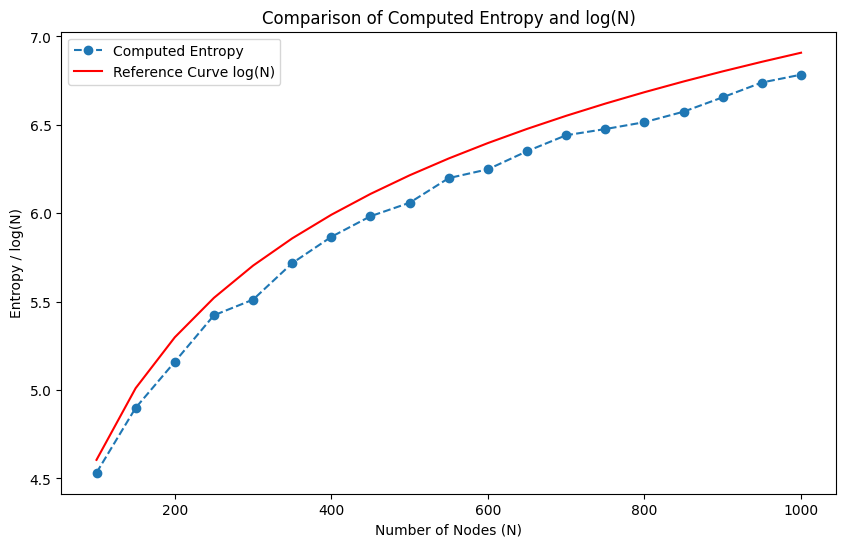

In [25]:
# Experiment Asymtptot RW is log(N) as N goes to infinity
lamda = 1
N_values = np.arange(100, 1001, 50)
entropies = []
log_N_values = []
c = 5
t = 100 # t = 2 * 1 / log(N)
time = [i for i in np.linspace(1,100,2)]


for N in N_values:
    p = c / N
    er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(N, p))
    er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
    er_rw.compute_laplacian_matrices(random_walk = True)

    er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
    er_rw.compute_transition_matrices(lamda=1)

    H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(len(time)-2, len(time)-1)))
    entropies.append(H_er_rw[list(H_er_rw.keys())[0]][-1])
    log_N_values.append(np.log(N))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_values, entropies, label="Computed Entropy", linestyle='--', marker='o')
plt.plot(N_values, log_N_values, label="Reference Curve log(N)", linestyle='-', color='r')
plt.xlabel("Number of Nodes (N)")
plt.ylabel("Entropy / log(N)")
plt.title("Comparison of Computed Entropy and log(N)")
plt.legend()
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/approximation_asymptot.png', format='png', dpi=300)
plt.show()

## Another Experiment (Long)

In [27]:
time = [i for i in np.linspace(1,20,2)]

# generate 2 2d grids for the x & y bounds
N = np.logspace(1, 3, 10, dtype=int)
C = np.linspace(1, 9, 20)

z = np.zeros((len(N),len(C)))
for i, n in enumerate(N):
    for j, c in enumerate(C):
        er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(n, c/(n-1)))
        er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
        er_rw.compute_laplacian_matrices(random_walk = True)

        er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
        er_rw.compute_transition_matrices(lamda=1)

        H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(len(time)-2, len(time)-1)))
        z[i,j] = H_er_rw[list(H_er_rw.keys())[0]][-1]

In [34]:
er_rw.T[1][0].toarray()

array([[0.00082578, 0.00068674, 0.00126239, ..., 0.00091848, 0.00103284,
        0.00069079],
       [0.0008012 , 0.00071165, 0.00126275, ..., 0.00092061, 0.00103655,
        0.00068964],
       [0.00080334, 0.00068877, 0.00128489, ..., 0.00091868, 0.00103465,
        0.00068948],
       ...,
       [0.00080367, 0.00069045, 0.00126318, ..., 0.00094039, 0.00103205,
        0.00069026],
       [0.00080332, 0.00069103, 0.00126458, ..., 0.00091738, 0.001048  ,
        0.00069069],
       [0.00080593, 0.00068964, 0.00126404, ..., 0.00092035, 0.00103603,
        0.00070722]])

<Axes: >

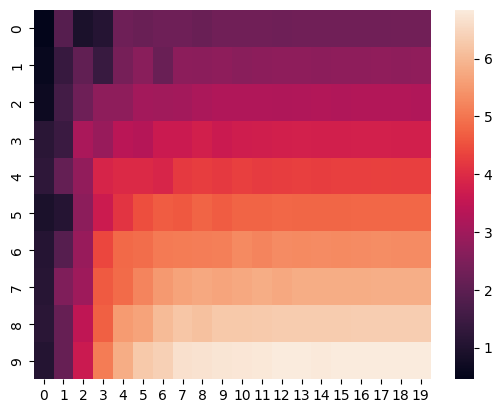

In [28]:
seaborn.heatmap(z)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


TypeError: Dimensions of C (60, 20) are incompatible with X (60) and/or Y (20); see help(pcolormesh)

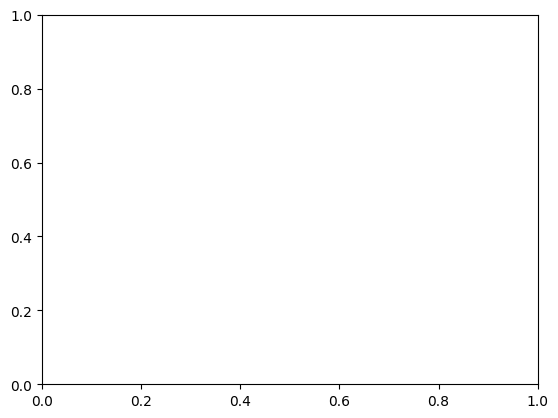

In [213]:
time = [i for i in np.linspace(1,20,2)]

# generate 2 2d grids for the x & y bounds
N = np.linspace(20, 50, 60, dtype=int)
C = np.linspace(1, 10, 20)

z = np.zeros((len(N),len(C)))
for i, n in enumerate(N):
    for j, c in enumerate(C):
        er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(n, c/(n-1)))
        er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
        er_rw.compute_laplacian_matrices(random_walk = True)

        er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
        er_rw.compute_transition_matrices(lamda=1)

        H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(len(time)-2, len(time)-1)))
        z[i,j] = H_er_rw[list(H_er_rw.keys())[0]][-1]

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
#z = z[:-1, :-1]
z_min, z_max = 0, np.max(z)

fig, ax = plt.subplots()

CC, NN = np.meshgrid(N, C)

c = ax.pcolormesh(NN, CC, z, cmap='RdBu', shading='nearest', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([NN.min(), NN.max(), CC.min(), CC.max()])
fig.colorbar(c, ax=ax)

plt.show()

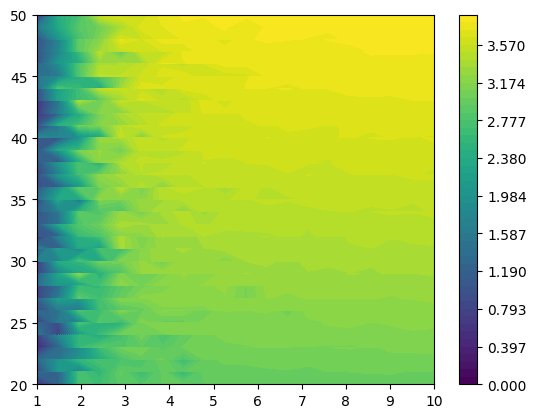

In [218]:
# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
z_min, z_max = 0, np.max(z)
levels = np.linspace(z_min, z_max, 50)

# plot
fig, ax = plt.subplots()

CC, NN = np.meshgrid(C, N)
c = ax.contourf(C, N, z, levels=levels)
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
time = [i for i in np.linspace(1,20,200)]

# generate 2 2d grids for the x & y bounds
N, C = np.meshgrid(np.linspace(20, 40, 10), np.linspace(1, 10, 10))
z = np.zeros((10,10))
for i, n in enumerate(N):
    for j, c in enumerate(C):
        er_adj = nx.adjacency_matrix(nx.erdos_renyi_graph(n, c/N-1))
        er_rw = StaticTempNetwork(times = time, adjacency = csr_matrix(er_adj))
        er_rw.compute_laplacian_matrices(random_walk = True)

        er_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
        er_rw.compute_transition_matrices(lamda=1)

        H_er_rw = compute_S_rate.compute_conditional_entropy(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(0, len(time)-1)))
        z[i,j] = H_er_rw[-1]

# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(N, C, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([N.min(), N.max(), C.min(), C.max()])
fig.colorbar(c, ax=ax)

plt.show()


fig, axs = plt.subplots(1,2, sharex=True, figsize=(10, 5))

####### RW Plot


axs[0].set_xlabel('t')
axs[0].set_ylabel('Sh')
axs[0].tick_params(axis='y')


axs[0].plot(time[1:], H_er_rw[list(H_er_rw.keys())[0]], label='rw conditional entropy of ER-graph')
asymptot = np.exp(H_er_rw[list(H_er_rw.keys())[0]][-1])
axs[0].plot(time, [0] + [K(t-t0, asymptot) for t in time[1:]], label='Reference full graph')


# Heat Plot

axs[1].set_xlabel('t')
axs[1].set_ylabel('Sh')
axs[1].tick_params(axis='y')


#axs[1].plot(time[1:], H_er_rw[list(H_er_rw.keys())[0]], label='heat conditional entropy of ER-graph')
asymptot = np.exp(H_er_rw[list(H_er_rw.keys())[0]][-1])
#axs[1].plot(time, [0] + [K(t-t0, asymptot) for t in time[1:]], label='Reference full graph')


# Adding titles to each subplot
axs[0].set_title('Random Walk Diffusion')
axs[1].set_title('Heat Diffusion')

# Adding a global title to the figure
fig.suptitle("Conditional Entropy of ER-graph vs Full Graph", fontsize=12)

# Adjusting the layout to make space for the global title
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

#plt.savefig('/home/b/skoove/Desktop/primary_school/vNS_d1d2.png', format='png', dpi=300)

plt.show()

## Entropy Production Rate

In [105]:
S_er_rw = compute_S_rate.compute_entropy_rate(net=er_rw, list_T=er_rw.T[1], lamda=1, force_csr=True, time_domain= list(np.arange(0, len(time)-2)))

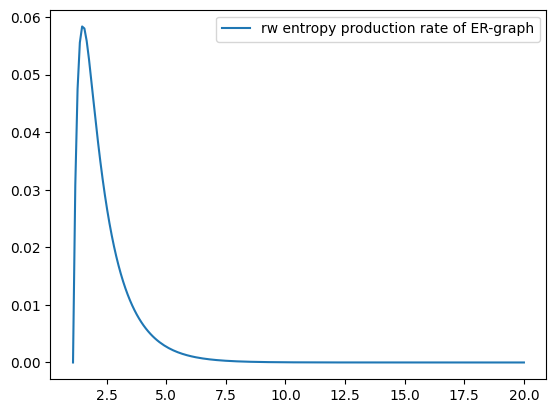

In [106]:
t0 = time[0]
plt.plot(time[1:], S_er_rw[list(H_er_rw.keys())[0]], label='rw entropy production rate of ER-graph')
plt.legend()

## RW-SBM

In [112]:
sbm = auxiliary_functions.stochastic_block_model(num_blocks=2, block_sizes=[N, 2*N], p_within_block=4/N, q_between_blocks=p/10)
sbm_adj = nx.adjacency_matrix(sbm)

In [145]:
sbm_rw_time = list(np.arange(0, 20, 1))

In [146]:
sbm_rw = StaticTempNetwork(times = sbm_rw_time, adjacency = csr_matrix(sbm_adj))
sbm_rw.compute_laplacian_matrices(random_walk = True)

sbm_rw.compute_inter_transition_matrices(lamda=1, dense_expm=False, use_sparse_stoch=False)
sbm_rw.compute_transition_matrices(lamda=1)

In [151]:
H_sbm_rw = compute_S_rate.compute_conditional_entropy(net=sbm_rw, list_T=sbm_rw.T[1], lamda=1, force_csr=True, time_domain= range(len(sbm_rw_time)-1))

In [154]:
sbm_rw_time[1:]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [153]:
print([0] + [K(t-t0, asymptot) for t in sbm_rw_time[1:]])

[0, nan, 3.7320230369473135, 4.599763313823575, 4.820107279227733, 4.871856727675638, 4.882497277823836, 4.884367540474462, 4.884655358596618, 4.8846962140948555, 4.884701796867892, 4.884702547996074, 4.884702648460238, 4.884702661867988, 4.8847026636559185, 4.884702663894271, 4.884702663926041, 4.884702663930277, 4.884702663930842, 4.884702663930916]


/tmp/ipykernel_3123958/3528920916.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))
/tmp/ipykernel_3123958/3528920916.py:3: RuntimeWarning: divide by zero encountered in log
  K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))
/tmp/ipykernel_3123958/3528920916.py:3: RuntimeWarning: invalid value encountered in scalar subtract
  K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))


/tmp/ipykernel_3123958/3528920916.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))
/tmp/ipykernel_3123958/3528920916.py:3: RuntimeWarning: divide by zero encountered in log
  K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))
/tmp/ipykernel_3123958/3528920916.py:3: RuntimeWarning: invalid value encountered in scalar subtract
  K = lambda t, n: np.log(n) - (n-1)/n*np.exp(-(n*t)/(n-1))*np.log((1+(n-1)*np.exp(-(n*t)/(n-1))) / (1-np.exp(- (n*t)/(n-1)))) - (n-1)/n * np.log(1-np.exp(-(n*t)/(n-1))) - 1/n*np.log(1+ (n-1)*np.exp((-n*t)/(n-1)))


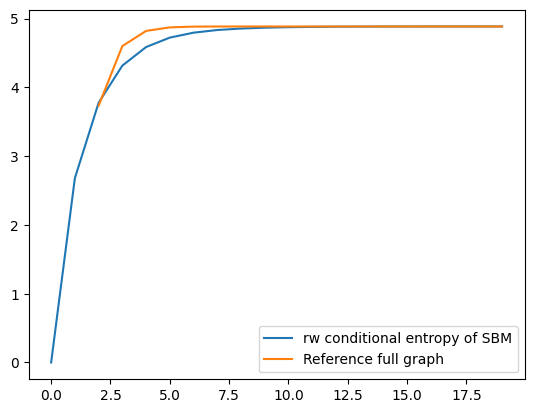

In [152]:
t0 = time[0]
plt.plot(sbm_rw_time, H_sbm_rw[list(H_sbm_rw.keys())[0]], label='rw conditional entropy of SBM')
asymptot = np.exp(H_sbm_rw[list(H_sbm_rw.keys())[0]][-1])
plt.plot(sbm_rw_time, [0] + [K(t-t0, asymptot) for t in sbm_rw_time[1:]], label='Reference full graph')
plt.legend()

In [147]:

S_sbm_rw = compute_S_rate.compute_entropy_rate(net=sbm_rw, list_T=sbm_rw.T[1], lamda=1, force_csr=True, time_domain= range(len(sbm_rw_time)-1))

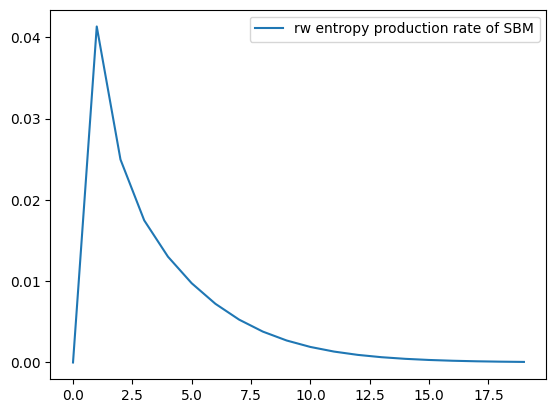

In [148]:

plt.plot(sbm_rw_time, S_sbm_rw[list(H_er_rw.keys())[0]], label='rw entropy production rate of SBM')
plt.legend()

# Comparison Analytical vs Simulation Diffusion

## Random Walk

In [ ]:
self_component_rw = [i.toarray()[0,0] for i in complete_graph_rw.T[1]]
others_component_rw = [i.toarray()[0,1] for i in complete_graph_rw.T[1]]

scrw = lambda t: 1 / N * ((N-1) * np.exp(-N/(N-1) * t) + 1)
ocrw = lambda t: 1 / N * (-np.exp(-N/(N-1) * t) + 1)

In [ ]:
from scipy.sparse.linalg import expm, eigsh
expm(-2*complete_graph_rw.laplacians).toarray()

## Heat

In [ ]:
self_component_heat = [i.toarray()[0,0] for i in complete_graph_heat.T[1]]
others_component_heat = [i.toarray()[0,1] for i in complete_graph_heat.T[1]]

sch = lambda t: 1 / N * (7 * np.exp(-N * t) + 1)
och = lambda t: 1 / N * (-np.exp(-N * t) + 1)

In [ ]:
plt.plot(time, [H(t) for t in time], label='Complete Graph')
plt.plot(time, [F(t) for t in time], label='Simple curve')
plt.plot(time, [K(t) for t in time], label=' True Complete Graph')
plt.plot(time[2:], S_complete_rw[list(S_complete_rw.keys())[0]], label='rw conditional entropy of complete graph')
plt.plot(time[2:], S_complete_heat[list(S_complete_heat.keys())[0]], label='heat conditional entropy of complete graph')
plt.legend()

In [ ]:
[K(t) for t in time]

In [ ]:
[K(t)-H(t) for t in time]